# Replicating 3B1B Wordle Video Code

I use turtle instead of manim and try to get close to what 3b1b produced in his video on wordle

In [1]:
import turtle, random
import math
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [2]:
with open ("sgb-words.txt", "r") as myfile:
    data = myfile.read().splitlines()

In [3]:
len(data)

5757

# The game

In [97]:
class wordle:
    def __init__(self):

        turtle.tracer(False)
        word_list = ['which', 'their', 'would', 'there', 'could', 'other', 'about', 'great', 'these', 'after', 'first', 'never', 'where', 'those', 'shall', 'being', 'might', 'every', 'think', 'under', 'found', 'still', 'while', 'again', 'place', 'young', 'years', 'three', 'right', 'house', 'whole', 'world', 'thing', 'night', 'going', 'heard', 'heart', 'among', 'asked', 'small', 'woman', 'whose', 'quite', 'words', 'given', 'taken', 'hands', 'until', 'since', 'light']
        answer = "found"#random.choice(word_list) # choose a random word from the list
        y = 250 # y location
        print(answer)
        
        for i in range(6): #Where the program starts
            guess_prompt = "What is guess "+str(i+1)+"?" #Makes a nice string for the prompt
            my_input = self.input_guess(guess_prompt) #calls input_guess function
            self.check_guess(my_input,answer,y)  #checks the guess
            y -= 75 #y down by 75
            if my_input == answer:
                turtle.penup()
                turtle.goto(-300,-200) #Always draws the congratulations in the same place
                turtle.color("black")
                turtle.write("Well Done!",font=("Verdana", 42, "normal"))
                break
                
        else: #Only runs if the for loop executes completely. i.e. You've used all your guesses.
            turtle.penup()
            turtle.goto(-300,-200)
            turtle.color("black")
            turtle.write("Answer was: ", answer,font=("Verdana", 42, "normal"))
        turtle.done() #Needs if you are using Pycharm and some other Python editors.
        

    def draw_square(self, x,y,col): # takes in x,y coordinates and a color
        turtle.penup()
        turtle.goto(x,y)
        turtle.pendown()
        turtle.fillcolor(col) # set the fillcolor
        turtle.begin_fill()     # start the filling color
        for i in range(4):     # drawing the square
            turtle.forward(60)
            turtle.right(90)
        turtle.end_fill() # ending the filling of the color

    def input_guess(self, prompt):
        my_input = turtle.textinput("5 letter word", prompt)

        while type(my_input) != str:
            my_input = turtle.textinput("Error", "Must be a string!")

        while len(my_input) != 5:
            my_input = turtle.textinput("Error", "Must be 5 characters long!")

        while my_input not in data:
            my_input = turtle.textinput("Error", "The word must exist!")

        return(my_input)

    def check_guess(self, my_input,answer,y):
        my_input = my_input.upper()

        x = -250 # x location
        for count, i in enumerate(my_input):
            if i == answer[count].upper(): self.draw_square(x,y,"#6BAA64") #exact character match draws a green square
            elif i in answer.upper(): self.draw_square(x,y,"#C9B457") #else if character anywhere in word draws yellow
            else: self.draw_square(x,y,"#787C7F") # otherwise draws red

            x += 75 # move x coordinate along by 75
        turtle.penup() #Moves the turtle penup
        
        x = -228 #225
        for i in range(len(my_input)):
            turtle.goto(x, y-42) # -40
            x += 75
            turtle.color("white")
            turtle.write(my_input[i],font=("Verdana", 15, "bold")) # font verdana, size 15, normal style




In [99]:
wordle()

found


## Selecting best guess, mutual information

In [4]:
def get_match(guess, answer):
    """
    Gets the outcome of a guess
    """
    match = []
    for i, j in zip(guess, answer):
        if i in answer:
            match.append(1) # orange
        elif i == j: 
            match.append(2) # green
        else: 
            match.append(0) # gray
    return(match)

In [5]:
# all possible permutations of outcomes
perms = np.array([roll for roll in product([0, 1, 2], repeat = 5)])

In [6]:
def get_word_dataframe(data):
    mat = np.empty((0, 5))
    for i in range(len(data)):
        row = []
        for j in range(5):
            row.append(data[i][j])
    #     print(row)
        row = np.expand_dims(np.array(row), axis = 0)
        mat = np.append(mat, row, axis=0)

    df = pd.DataFrame(mat)
    df.to_csv("5_letter_words.csv", index = False)

In [7]:
df = pd.read_csv("5_letter_words.csv", index_col = False)
df.columns = range(5)

In [46]:
def get_words_from_match(word, match, df):
    """
    Gets the words that match the condition
    """
    subset = df.copy()
    for index, i in enumerate(match):
        if i == 0:
#             subset = subset.loc[subset[index] != word[index]]
            subset = subset.loc[(subset == word[index]).sum(axis = 1) == 0]
        elif i == 1:
            subset = subset.loc[((subset == word[index]).sum(axis = 1) >= 1) & (subset[index] != word[index])] # check if the word is in each row by summing over truth table
            # should also remove the ones where it is on the same row
            
        elif i == 2:
            subset = subset.loc[subset[index] == word[index]]
    return(subset)

In [50]:
get_words_from_match("tired", [2,1,1,1,0], df) # anagrams their

,0,1,2,3,4
2,t,h,e,i,r
475,t,r,i,b,e
2707,t,r,i,p,e
2756,t,r,i,t,e
3493,t,r,i,c,e
3777,t,r,i,k,e


In [66]:
get_words_from_match("mates", [1,1,1,1,1], df) # anagrams with no letters on same spots

,0,1,2,3,4
361,s,t,e,a,m


In [67]:
get_words_from_match("which", [2,2,2,2,2], df) # same word

,0,1,2,3,4
0,w,h,i,c,h


In [68]:
def get_probability(word):
    """
    Get the probability of each outcome of the word with respect to each permuation
    """
    p = []
    for i in perms:
        p.append(len(get_words_from_match(word, i, df)))
    return(np.array(p)/sum(p))

In [81]:
p = get_probability("tares")

In [82]:
# distribution of probabilities for each permutation
def plot_dist(p):
    plt.bar(range(len(p)), sorted(p, reverse = True))
    plt.xlabel("Least to most useful permutation")
    plt.ylabel("Percentage of words left")

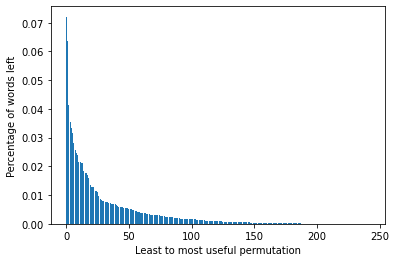

In [83]:
plot_dist(p)

In [84]:
def calc_info(p):
    # calculate expected information
    E = 0
    z = 0
    for i in p:
    #     print(i)
        if i != 0:
            E += i*math.log(1/i, 2)
        else:
            z+= 1
#     print(z)
    return(E)

In [85]:
calc_info(p)

6.209181059719009

## Initial Entropy

In [ ]:
# value = {}
# for index, word in enumerate(data):
#     p = get_probability(word)
#     # calculate expected information
#     value[word] = calc_info(p)
    
#     if index%100 == 0:
#         print(index , "/", len(data))

0 / 5757
100 / 5757
200 / 5757
300 / 5757
400 / 5757
500 / 5757
600 / 5757
700 / 5757
800 / 5757
900 / 5757
1000 / 5757
1100 / 5757
1200 / 5757
1300 / 5757
1400 / 5757
1500 / 5757
1600 / 5757
1700 / 5757
1800 / 5757
1900 / 5757
2000 / 5757
2100 / 5757
2200 / 5757
2300 / 5757


In [ ]:
# sorted_dict = dict(sorted(value.items(), key=lambda item: item[1]))

In [ ]:
# import pickle
# with open('saved_values.pkl', 'wb') as f:
#     pickle.dump(sorted_dict, f)

## Playing a Game

In [76]:
def check_guess(guess, answer):
    ret = []
    for i, j in zip(guess, answer):
        if i == j:
            ret.append(2)
        elif i in answer:
            ret.append(1)
        else: 
            ret.append(0)
    return(ret)

In [77]:
# Answer is found
answer = "found"

In [78]:
initial_entropy = pickle.load(open("saved_values.pkl", "rb"))

<BarContainer object of 10 artists>

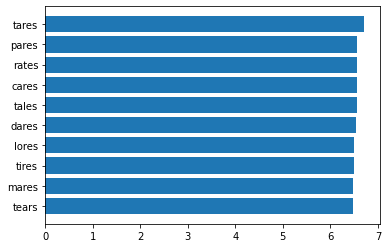

In [79]:
plt.barh(list(initial_entropy.keys())[-10:], list(initial_entropy.values())[-10:])

In [80]:
def compute_entropy_dict(data):
    value = {}
    for index, word_vec in enumerate(data.iterrows()):
        word = "".join(word_vec[1].values)
        p = get_probability(word)
        # calculate expected information
        value[word] = calc_info(p)

#         if index%100 == 0:
#             print(index , "/", len(data))
    return(value)

In [35]:
record = {"Iter":[], "N": [], "Guess":[], "Entropy": []}

In [36]:
def play_wordle(answer, df = df):
    index = 0
    converge = False
    record = {"Iter":[], "N": [], "Guess":[], "Entropy": []}
    
    while converge == False:
        
        if len(df) == 5757:
            guess = list(initial_entropy.keys())[-1]
            max_e = list(initial_entropy.values())[-1]
        else:
            entropy = compute_entropy_dict(df) # compute entropy for remaining
            guess = max(entropy, key=entropy.get)
            max_e = max(entropy.values())
        
        
        print("Iteration: ", index, ", possible words before guess:", len(df), ", current guess:", guess, ", entropy: ", max_e)
        record["Iter"].append(index)
        record["N"].append(len(df))
        record["Guess"].append(guess)
        record["Entropy"].append(max_e)
        
        if guess == answer:
            converge = True
            print("Success!")
        
        else:
            vec = check_guess(guess, answer)
            df = get_words_from_match(guess, vec, df) 
        
        index += 1
    return(record)

In [96]:
play_wordle("found")

Iteration:  0 5757 tares
0 / 415
100 / 415
200 / 415
300 / 415
400 / 415
Iteration:  1 415 doily
0 / 12
Iteration:  2 12 pound
0 / 5
Iteration:  3 5 bound
0 / 4
Iteration:  4 4 mound
0 / 3
Iteration:  5 3 hound
0 / 2
Iteration:  6 2 found
Success!


In [42]:
word_list = ['which', 'their', 'would', 'there', 'could', 'other', 'about', 'great', 'these', 'after', 'first', 'never', 'where', 'those', 'shall', 'being', 'might', 'every', 'think', 'under', 'found', 'still', 'while', 'again', 'place', 'young', 'years', 'three', 'right', 'house', 'whole', 'world', 'thing', 'night', 'going', 'heard', 'heart', 'among', 'asked', 'small', 'woman', 'whose', 'quite', 'words', 'given', 'taken', 'hands', 'until', 'since', 'light']
        

In [44]:
records = []
for i in word_list:
    print(i)
    word_record = play_wordle(i)
    word_record["word"] = [i]*len(word_record["Iter"])
    records.append(word_record)

which
Iteration:  0 , possible words before guess: 5757 , current guess: tares , entropy:  6.708347366665026
Iteration:  1 , possible words before guess: 415 , current guess: doily , entropy:  5.482617360573649
Iteration:  2 , possible words before guess: 13 , current guess: chink , entropy:  4.8643410270346985
Iteration:  3 , possible words before guess: 3 , current guess: chimp , entropy:  4.629405676115274
Iteration:  4 , possible words before guess: 2 , current guess: which , entropy:  3.848004474526619
Success!
their
Iteration:  0 , possible words before guess: 5757 , current guess: tares , entropy:  6.708347366665026
Iteration:  1 , possible words before guess: 38 , current guess: tired , entropy:  6.066474122203177
Iteration:  2 , possible words before guess: 12 , current guess: tiler , entropy:  6.056200691979593
Iteration:  3 , possible words before guess: 5 , current guess: timer , entropy:  5.827027516700695
Iteration:  4 , possible words before guess: 4 , current guess: tig

KeyboardInterrupt: 